In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from math import sqrt

BASE = Path("..")
DATA_INTERIM = BASE / "data" / "interim"
MODEL_DIR = BASE / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Paths ready")


✅ Paths ready


In [2]:
ext_file = DATA_INTERIM / "features_extended.parquet"
assert ext_file.exists(), "Run 04b_feature_engineering_extended.ipynb first!"
df = pd.read_parquet(ext_file)

print("Rows:", df.shape[0], "Cols:", df.shape[1])
df.head()


Rows: 19098 Cols: 16


,event_type,state,month,season,magnitude,magnitude_type,begin_lat,begin_lon,damage_property_num,region,lat_bin,lon_bin,event_group,event_season,state_event,state_event_avg_damage
0,Thunderstorm Wind,GEORGIA,3,MAM,52.0,EG,33.4757,-85.238,1000.0,South,"(30, 35]","(-90, -85]",Thunderstorm Wind,Thunderstorm Wind_MAM,GEORGIA_Thunderstorm Wind,2487.808896
1,Tornado,MICHIGAN,3,MAM,50.0,Unknown,41.7900,-86.100,100000.0,Midwest,"(40, 45]","(-90, -85]",Tornado,Tornado_MAM,MICHIGAN_Tornado,18214.285714
2,Flash Flood,TENNESSEE,4,MAM,50.0,Unknown,36.0300,-89.330,0.0,Other,"(35, 40]","(-90, -85]",Flash Flood,Flash Flood_MAM,TENNESSEE_Flash Flood,14266.428571
3,Thunderstorm Wind,TENNESSEE,4,MAM,52.0,EG,36.1800,-88.160,0.0,Other,"(35, 40]","(-90, -85]",Thunderstorm Wind,Thunderstorm Wind_MAM,TENNESSEE_Thunderstorm Wind,9633.411765
4,Flash Flood,TENNESSEE,4,MAM,50.0,Unknown,36.3000,-88.710,0.0,Other,"(35, 40]","(-90, -85]",Flash Flood,Flash Flood_MAM,TENNESSEE_Flash Flood,14266.428571


In [3]:
target_col = "damage_property_num"

# Drop raw identifiers if present
ignore_cols = [target_col, "event_type"]  
features = [c for c in df.columns if c not in ignore_cols]

X = df[features]
y = df[target_col].astype(float)

print("Features:", len(features))
print("Target sample:", y.head())


Features: 14
Target sample: 0      1000.0
1    100000.0
2         0.0
3         0.0
4         0.0
Name: damage_property_num, dtype: float64


In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "string", "category"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

X_enc = preprocessor.fit_transform(X)
joblib.dump(preprocessor, DATA_INTERIM / "extended_feature_preprocessor.joblib")

print("Encoded shape:", X_enc.shape)


Encoded shape: (19098, 443)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42
)

y_train_class = (y_train > 0).astype(int)
y_test_class  = (y_test > 0).astype(int)


In [6]:
clf = RandomForestClassifier(
    n_estimators=300, max_depth=12, class_weight="balanced", random_state=42, n_jobs=-1
)
clf.fit(X_train, y_train_class)

clf_preds = clf.predict(X_test)
clf_probs = clf.predict_proba(X_test)[:,1]

print("Classifier Accuracy:", accuracy_score(y_test_class, clf_preds))
print("Classifier F1:", f1_score(y_test_class, clf_preds))


Classifier Accuracy: 0.8740837696335079
Classifier F1: 0.8139264990328821


In [10]:
# Boolean masks
mask_train = (y_train > 0).values if hasattr(y_train, "values") else (y_train > 0)
mask_test  = (y_test > 0).values if hasattr(y_test, "values") else (y_test > 0)

# Convert to integer positions
train_idx = np.where(mask_train)[0]
test_idx  = np.where(mask_test)[0]

# Ensure y arrays are numpy (not pandas Series)
y_train_np = np.array(y_train)
y_test_np  = np.array(y_test)

# Train regressor only on non-zero rows
reg = GradientBoostingRegressor(n_estimators=400, learning_rate=0.05, random_state=42)
reg.fit(X_train[train_idx], y_train_np[train_idx])

# Evaluate only on non-zero test rows
reg_preds = reg.predict(X_test[test_idx])
print("Regressor RMSE (>0):", sqrt(mean_squared_error(y_test_np[test_idx], reg_preds)))
print("Regressor MAE (>0):", mean_absolute_error(y_test_np[test_idx], reg_preds))




Regressor RMSE (>0): 95348.90649769198
Regressor MAE (>0): 35638.28536291412


In [11]:
# Ensure y_test is numpy
y_test_np = np.array(y_test)

# Get classifier probabilities for all test rows
clf_probs = clf.predict_proba(X_test)[:, 1]

# Get regressor predictions for all test rows
reg_all_preds = reg.predict(X_test)

# Final blended prediction = probability of damage × estimated amount
final_preds = clf_probs * reg_all_preds

# Evaluate metrics
rmse = sqrt(mean_squared_error(y_test_np, final_preds))
mae  = mean_absolute_error(y_test_np, final_preds)
r2   = r2_score(y_test_np, final_preds)

print(f"Two-stage extended -> RMSE: {rmse:,.0f}, MAE: {mae:,.0f}, R²: {r2:.3f}")


Two-stage extended -> RMSE: 61,648, MAE: 18,299, R²: 0.179


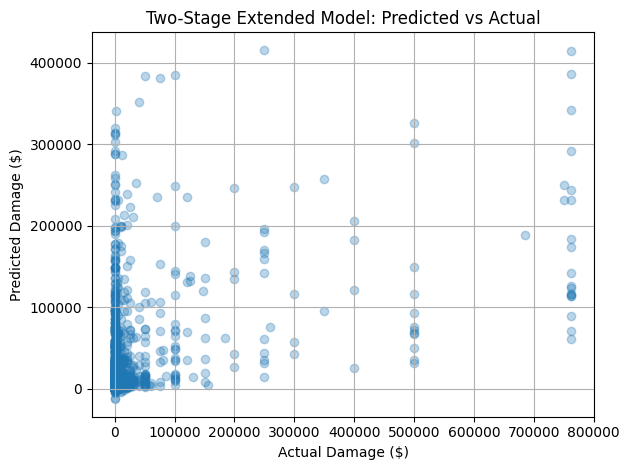

In [12]:
plt.scatter(y_test_np, final_preds, alpha=0.3)
plt.xlabel("Actual Damage ($)")
plt.ylabel("Predicted Damage ($)")
plt.title("Two-Stage Extended Model: Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()
